# Sourcing Agent Prototype using LangGraph


In [1]:
import os
import json
import random
from collections import defaultdict
from typing import List, Tuple

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
# from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate
from typing_extensions import List, TypedDict


load_dotenv()
os.environ.get("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:

prompt = PromptTemplate.from_template("""HUMAN\n
                                               You are a useful assistant. Answer as best as you can the question below, with maximum of one sentence. Be concise!\n
                                               Question: {question}\n                                                
                                               Answer:
                                               """)


class State(TypedDict):
    question : str
    # context : List[Document]
    answer: str

def generate(state : State):
    message = prompt.invoke({"question":state["question"]})
    response = llm.invoke(message)
    return({"answer":response})

graph_builder = StateGraph(State)
graph_builder.add_sequence([generate])
graph_builder.add_edge(START, "generate")
graph = graph_builder.compile()

In [9]:
output = graph.invoke({"question":"when is London become the capital of United Kingdom"})

In [12]:
print(output['answer'].content)

London became the capital of the United Kingdom in the 13th century, specifically around the time of King Edward I's reign in the late 1200s.


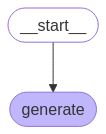

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## ReAct Agent

In [15]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# search tools
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()



In [16]:
search.invoke("who is leonardo dicaprio?")

"Leonardo DiCaprio (born November 11, 1974, Los Angeles, California, U.S.) is an American actor and producer who emerged in the 1990s as one of Hollywood's leading performers, noted for his portrayals of unconventional and complex characters.. DiCaprio first acted at age five, performing on the children's television show Romper Room, and, as a teenager, he made numerous commercials and ... Leonardo DiCaprio kept a low profile in a face mask and baseball cap as he exited a star-studded dinner bash at Frame in Paris on Saturday night.. The Hollywood actor, 50, attempted to make a low ... Leonardo DiCaprio, born Nov 11, 1974, in LA, is an acclaimed actor with a $300M net worth. Known for roles in Titanic & The Revenant, he has won an Oscar & 3 Golden Globes. Famous for high-profile relationships, his focus remains on his film career Leonardo DiCaprio's estimated net worth is approximately $300 million, reflecting his success as one of Hollywood's most sought-after leading men. Throughout 

In [19]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

tools = [add, multiply, divide, search]
llm_with_tools = llm.bind_tools(tools)

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs")

def reasoner(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

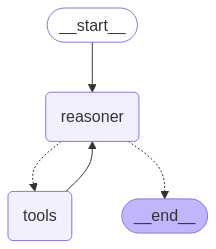

In [26]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "reasoner") 
builder.add_conditional_edges(
    "reasoner", 
    tools_condition
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [23]:
messages = [HumanMessage(content="What is 2 times height of the Eiffel Tower?")]
messages = react_graph.invoke({"messages": messages})   

In [24]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times height of the Eiffel Tower?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_DVEanIK58vldejndnNZ9p2bP)
 Call ID: call_DVEanIK58vldejndnNZ9p2bP
  Args:
    query: height of the Eiffel Tower in meters
================================= Tool Message =================================
Name: duckduckgo_search

The Eiffel Tower, in Paris, France, reaches a height of 330 meters (1,083 feet). Completed in 1889 by engineer Gustave Eiffel, this iron lattice structure is the tallest in the city. Known as La Tour Eiffel, it symbolizes Paris and draws millions of visitors each year. The Eiffel Tower Height Originally 300 meters (984 feet) tall, the Eiffel Tower now stands at 330 meters (1,083 feet) due to the addition of antennas. The Eiffel Tower Construction Period Built ... The official height of the Eiffel Tower is 984 feet. Howeve

## Supposedly more "manual" way of building ReAct Agent (I am not sure tho)

In [27]:
def reasoner2(state):
    query = state["query"]
    messages = state["messages"]
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages": result}



In [28]:
tools = [add, multiply, divide, search]

llm2 = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools2 = llm2.bind_tools(tools)



In [29]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    """State of the graph."""
    query: str    
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]


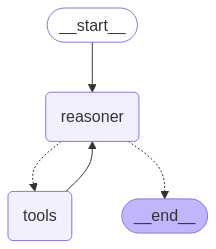

In [31]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode


# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner2)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
response = react_graph.invoke({"query": "What is 2 times height of the Eiffel Tower?"})   
# response['messages'].pretty_print()
print(response)

{'query': 'What is 2 times height of the Eiffel Tower?', 'messages': [HumanMessage(content='What is 2 times height of the Eiffel Tower?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ITP1P2fk8F9z251MXzPi492k', 'function': {'arguments': '{"query":"height of the Eiffel Tower"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 190, 'total_tokens': 212, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d9aa3e44-676e-4a5f-b8a0-7c122a00ba08-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'height of the Eiffel Tower'}, 'id':

In [37]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times height of the Eiffel Tower?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_ITP1P2fk8F9z251MXzPi492k)
 Call ID: call_ITP1P2fk8F9z251MXzPi492k
  Args:
    query: height of the Eiffel Tower
================================= Tool Message =================================
Name: duckduckgo_search

Eiffel Tower: 330 m (1,080 ft) [4] 1889: Lattice Tower ... Tower Pinnacle height Year Country City Remarks Sapporo TV Tower: 147.2 m 1957 Learn about the height of the Eiffel Tower, how it was constructed, and why it is a symbol of Paris. Find out how its height varies with temperature, how it compares to other landmarks, and how it changed over time. The official height of the Eiffel Tower is 984 feet. However, if you include the broadcast antenna that now sits at the top, the entire tower measures approximately 1,083 feet. It rec

# Sourcing Agent Build

Agent: 
Resume sourcing from a set of job requirement and a set of resume

Inputs: 
- linkedin profile(s) as resume
- job requirement

Tasks:
- Get linkedin profile and safe
- Evaluate the resume to the job requirement, score
- Decide to send email or not from score
- Write email, some initial questions from the resume screening process
- Send email

Tools:
- Web scrape, linkedin
- Profile reader/writer to document
- Job requirement reader/retrieval?
- Send Email







In [5]:
from typing import Dict, List, Tuple, Any, Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, AnyMessage
from langchain_core.tools import BaseTool
from langgraph.graph import START, StateGraph, END
from langchain_core.agents import AgentAction, AgentFinish
from langchain_openai import ChatOpenAI
import operator
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from IPython.display import Image, display

In [ ]:
# Tools

def pull_resume(linkedin_URL: int) -> str:
    """pull linkedin profile from a linkedin profile URL.

    Args:
        linkedin_URL: URL of linkedin profile        
    """

    profile_raw = ""

    return profile_raw

def pull_job_desc() -> str:
    """no argument, just do pull job description for current task.

    Args:
          
    """

    profile_raw = ""

    return profile_raw

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini")

tools = [pull_resume, pull_job_desc]
llm_with_tools = llm.bind_tools(tools)

sys_msg = SystemMessage(content="You are a helpful assistant tasked with sourcing candidate resume, evaluate his/her resume to the job posting, and deciding if they suit the position or not.")

def sourcing_agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("sourcing_agent", sourcing_agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "sourcing_agent") 
builder.add_conditional_edges( #conditional edge for tool
    "sourcing_agent", 
    tools_condition
)
builder.add_edge("tools", "sourcing_agent") #back to agent

react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
for m in response['messages']:
    m.pretty_print()

PydanticUserError: Field 'name' defined on a base class was overridden by a non-annotated attribute. All field definitions, including overrides, require a type annotation.

For further information visit https://errors.pydantic.dev/2.10/u/model-field-overridden

In [ ]:
messages = [HumanMessage(content="What is 2 times height of the Eiffel Tower?")]
messages = react_graph.invoke({"messages": messages})   

In [ ]:
for m in messages['messages']:
    m.pretty_print()